##Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Installing and Importing Required Libraries

In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.10.0
!pip install keras==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tarfile
from glob import glob
import nibabel as nib
import cv2

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.optimizers import Adam
from keras import backend as K

from tqdm import tqdm

In [ ]:
from itertools import chain
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


##Visualizing And PreProcessing Dataset

###Visualizing

In [ ]:
dataset_path = "/content/drive/MyDrive/ImageLabelDS.csv"

In [ ]:
dataset = pd.read_csv(dataset_path)
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset.head()

,Image Slices,Label Slices
0,/content/drive/MyDrive/Capstone4/ImageSlices/c...,/content/drive/MyDrive/Capstone4/LabelSlices/c...
1,/content/drive/MyDrive/Capstone4/ImageSlices/c...,/content/drive/MyDrive/Capstone4/LabelSlices/c...
2,/content/drive/MyDrive/Capstone4/ImageSlices/c...,/content/drive/MyDrive/Capstone4/LabelSlices/c...
3,/content/drive/MyDrive/Capstone4/ImageSlices/c...,/content/drive/MyDrive/Capstone4/LabelSlices/c...
4,/content/drive/MyDrive/Capstone4/ImageSlices/c...,/content/drive/MyDrive/Capstone4/LabelSlices/c...


In [ ]:
def plot_images(df):
    
  idx = random.randint(0,len(df))
    
  image = cv2.imread(df['Image Slices'][idx])
  mask = cv2.imread( df['Label Slices'][idx])
    
  fig, axs = plt.subplots(1,3, figsize=[13,15])
    
  axs[0].imshow(image)
  axs[0].set_title("Colon Cancer Slice")
    
  plt.grid(False)
    
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
    
  plt.grid(False)
    
  axs[2].imshow(image)
  axs[2].imshow(mask, alpha=0.3)
  axs[2].set_title('Cancer with mask')
    
  plt.grid(False)
  plt.show()

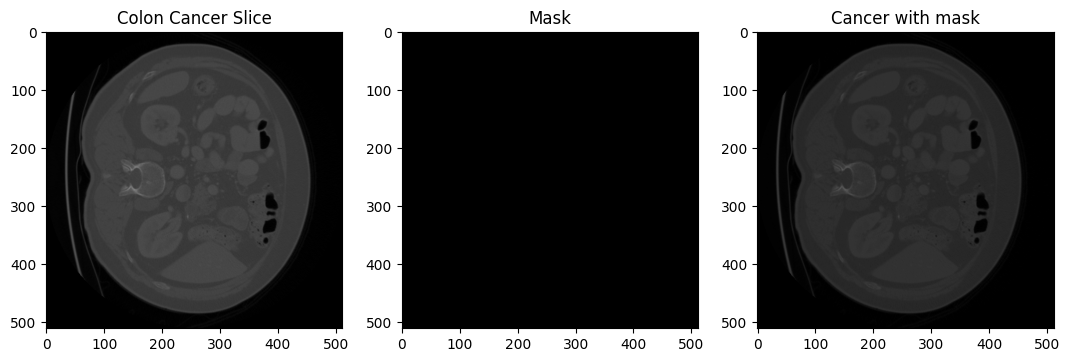

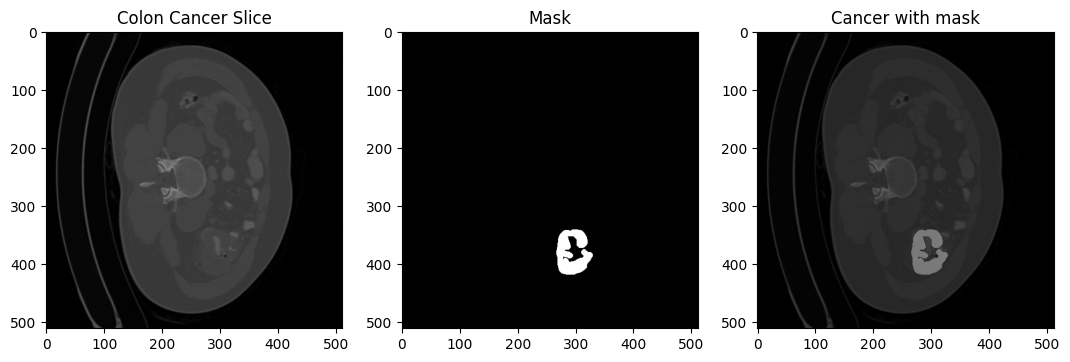

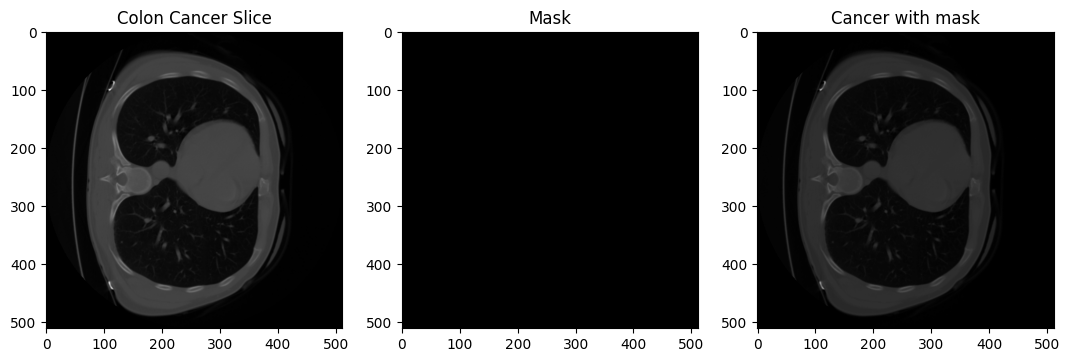

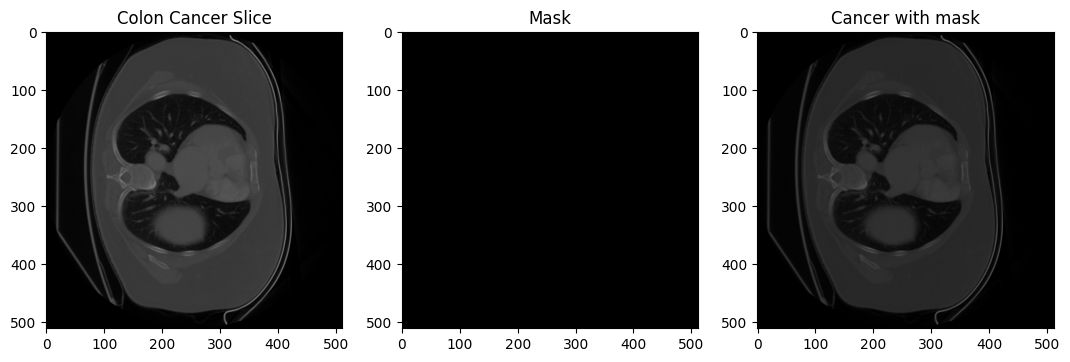

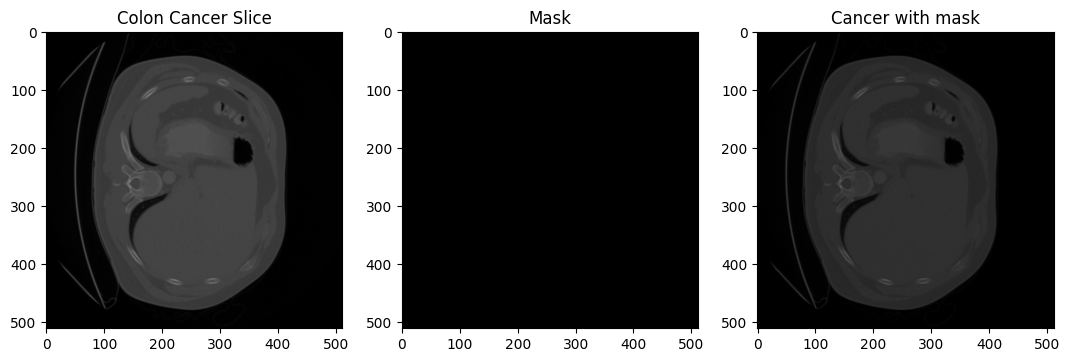

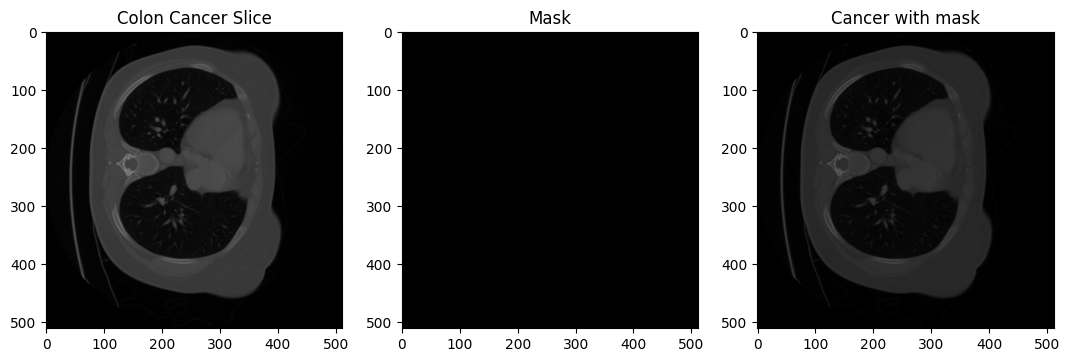

In [ ]:
for i in range(6):
  plot_images(dataset)

###Splitting Into Train and Val set

In [ ]:
train_df, val_df = train_test_split(dataset, test_size=0.25, random_state = 123)

In [ ]:
print(train_df.shape, val_df.shape)

(10114, 2) (3372, 2)


###Data Augmentation

In [ ]:
#hyperparameters
EPOCHS = 5
BATCH_SIZE = 64
IMGHEIGHT = 128
IMGWIDTH = 128
CHANNELS = 3

In [ ]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train_df,
                                            x_col="Image Slices",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMGHEIGHT,IMGWIDTH),
                                            color_mode='rgb')
# mask train generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train_df,
                                            x_col="Label Slices",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMGHEIGHT,IMGWIDTH),
                                            color_mode='grayscale')

Found 10114 validated image filenames.
Found 10114 validated image filenames.


In [ ]:
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
valimage_generator=imagegen.flow_from_dataframe(dataframe=val_df,
                                            x_col="Image Slices",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMGHEIGHT,IMGWIDTH),
                                            color_mode='rgb')
# mask train generator
valmask_generator=maskgen.flow_from_dataframe(dataframe=val_df,
                                            x_col="Label Slices",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMGHEIGHT,IMGWIDTH),
                                            color_mode='grayscale')

Found 3372 validated image filenames.
Found 3372 validated image filenames.


In [ ]:
def data_iterator(image_gen,mask_gen):
  for img, mask in zip(image_gen,mask_gen):
      yield img, mask

In [ ]:
train_gen = data_iterator(timage_generator, tmask_generator)
val_gen = data_iterator(valimage_generator,valmask_generator)

## Model Building

###Defining IoU and Dice Coefficient Metrics

In [ ]:
def iou(ytrue, ypred):
    smoothing_factor=0.1
    intersection = K.sum(ytrue*ypred)
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

# Dice Sorenson
def dice_coef(ytrue, ypred):
    smoothing_factor=0.1
    ytrue_f = K.flatten(ytrue)
    ypred_f = K.flatten(ypred)
    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    combined_area = ytrue_area + ypred_area
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = valimage_generator.n/BATCH_SIZE

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

158.03125 52.6875


###Training Resnet Unet Model

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
unet_resnet = sm.Unet(BACKBONE, encoder_weights='imagenet') #weights were assigned using imagenet
unet_resnet.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])
print(unet_resnet.summary())

85521592/85521592 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [ ]:
callbacks_resnet = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-5, verbose=1),
]

In [ ]:
history_res_unet = unet_resnet.fit(train_gen,
                                   steps_per_epoch = STEP_SIZE_TRAIN,
                                   epochs=EPOCHS,
                                   callbacks=callbacks_resnet,
                                   validation_data=val_gen,
                                   validation_steps=STEP_SIZE_VALID)

In [ ]:
#saving the model
unet_resnet.save("/content/drive/MyDrive/Capstone4/model_resnet2.h5")

###Plotting graph

In [ ]:
history_res_unet.history.keys()

dict_keys(['loss', 'accuracy', 'iou', 'dice_coef', 'precision', 'val_loss', 'val_accuracy', 'val_iou', 'val_dice_coef', 'val_precision', 'lr'])

In [ ]:
def show_graph(history):
  loss_train =history.history['loss']
  loss_val = history.history['val_loss']
  dice_train = history.history['dice_coef']
  dice_val = history.history['val_dice_coef']
  iou_train = history.history['iou']
  iou_val = history.history['val_iou']
  precision_train = history.history['precision']
  precision_val = history.history['val_precision']
  epochs = range(len(loss_train))

  plt.figure(figsize=(15,10))
  plt.subplot(2,2,1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'r', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2,2,2)
  plt.plot(epochs, dice_train, 'g', label='Training Dice')
  plt.plot(epochs, dice_val, 'r', label='validation Dice')
  plt.title('Training and Validation Dice Co-efficient')
  plt.xlabel('Epochs')
  plt.ylabel('Dice Co-efficient')
  plt.legend()

  plt.subplot(2,2,3)
  plt.plot(epochs, iou_train, 'g', label='Training IOU')
  plt.plot(epochs, iou_val, 'r', label='validation IOU')
  plt.title('Training and Validation IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()

  plt.subplot(2,2,4)
  plt.plot(epochs, precision_train, 'g', label='Training Precision')
  plt.plot(epochs, precision_val, 'r', label='validation Precision')
  plt.title('Training and Validation Precision')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

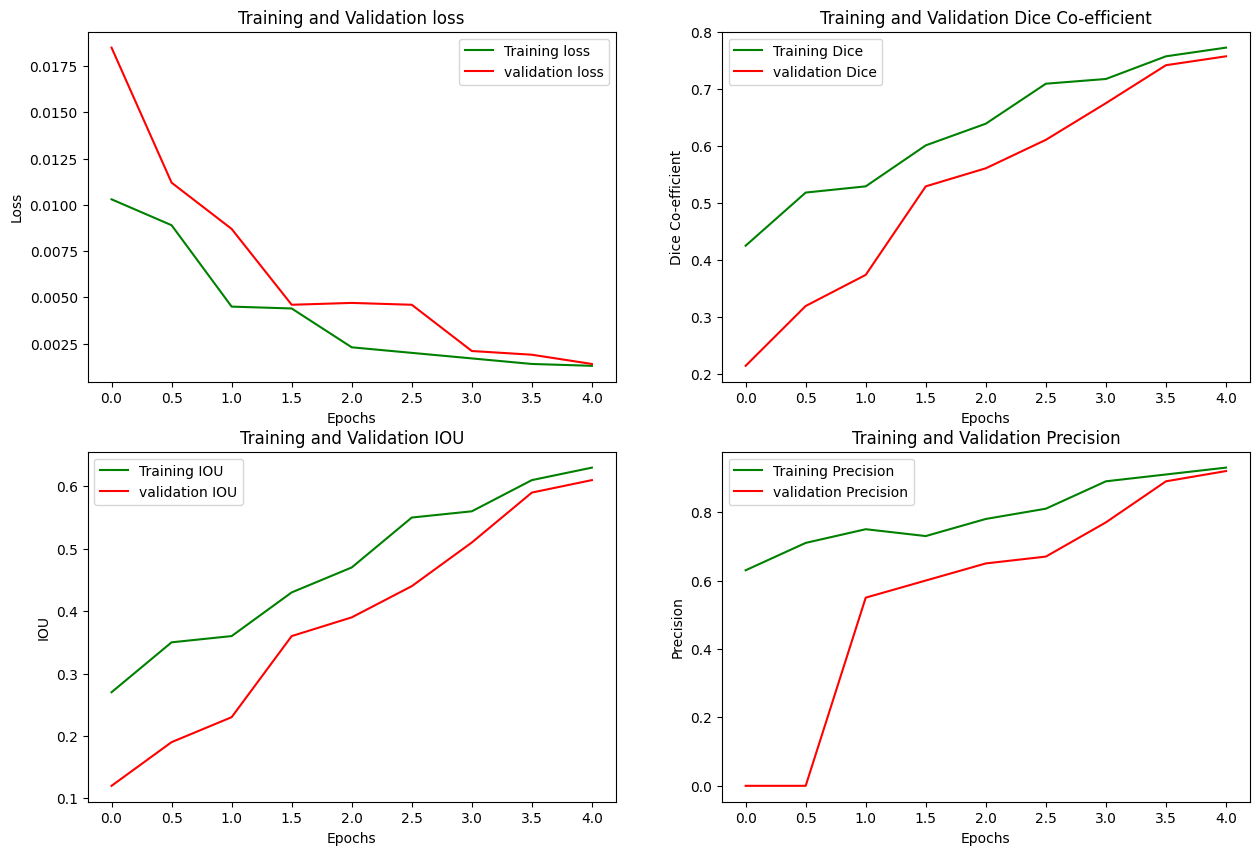

In [ ]:
show_graph(history_res_unet)

###Predictions

1/1 [==============================] - 0s 28ms/step


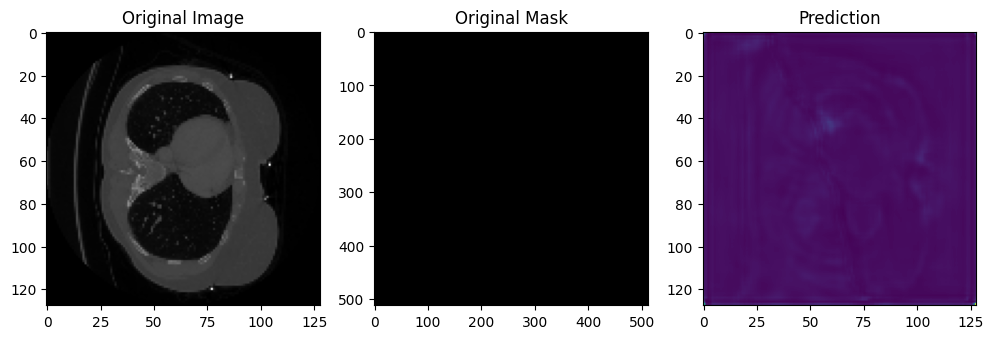

1/1 [==============================] - 0s 25ms/step


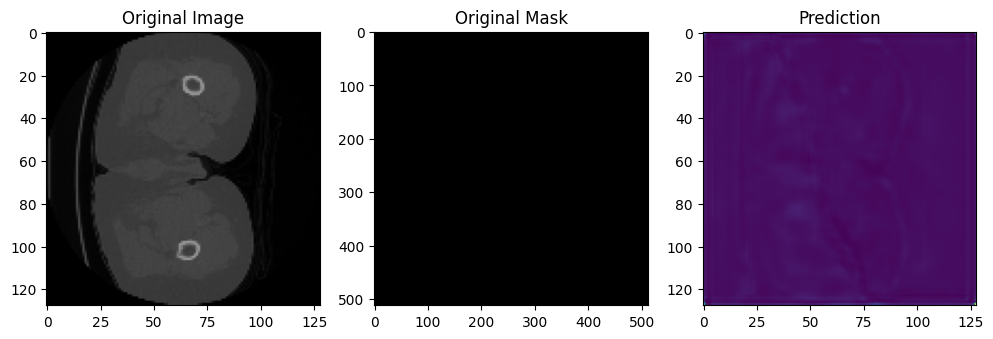

1/1 [==============================] - 0s 34ms/step


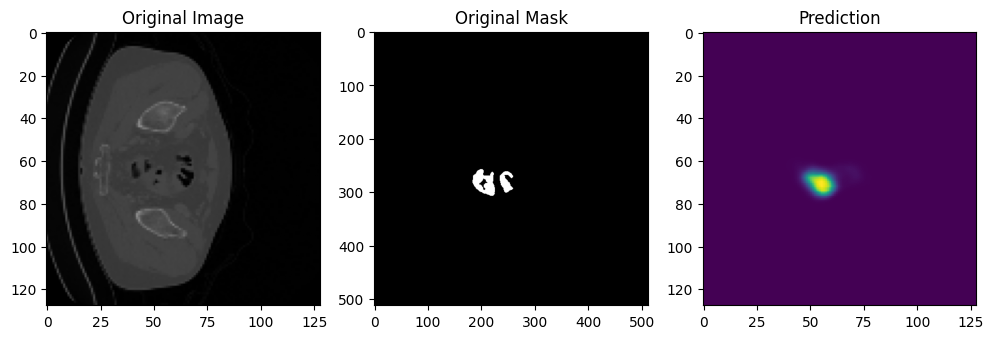

1/1 [==============================] - 0s 31ms/step


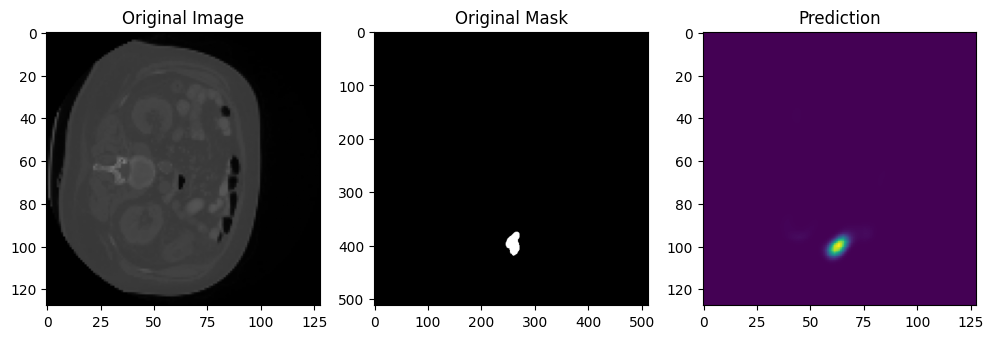

1/1 [==============================] - 0s 26ms/step


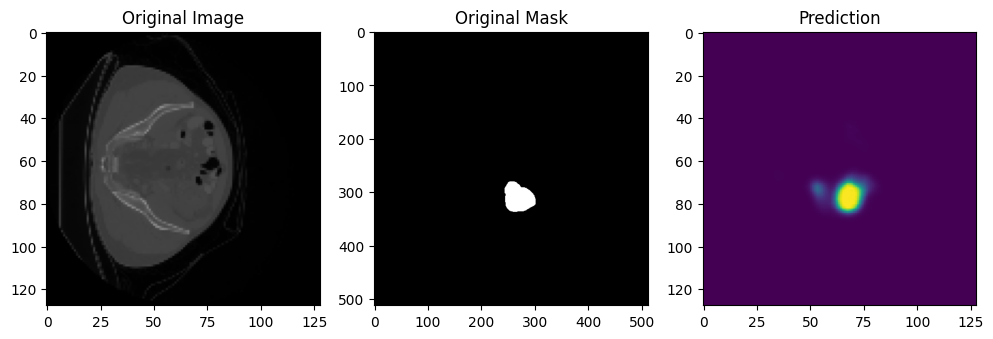

1/1 [==============================] - 0s 25ms/step


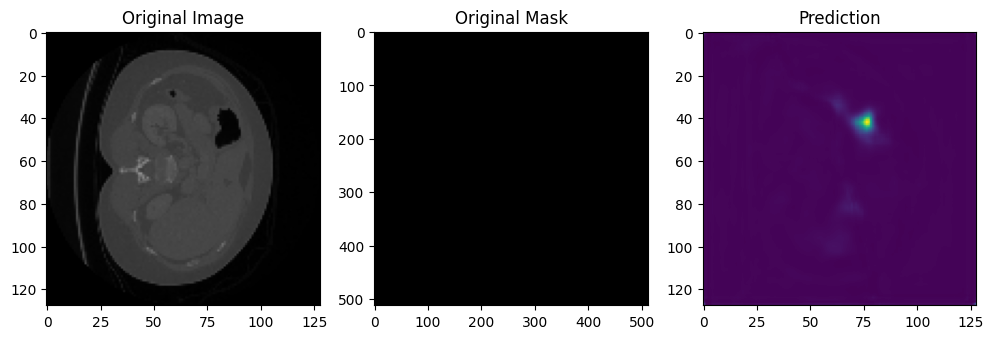

1/1 [==============================] - 0s 28ms/step


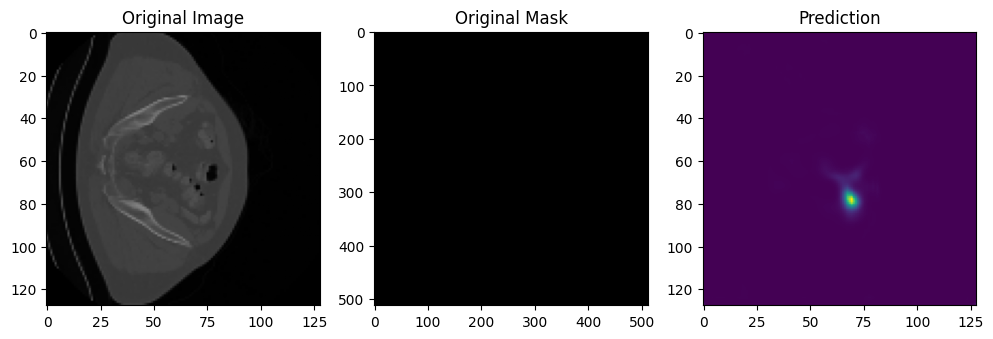

1/1 [==============================] - 0s 28ms/step


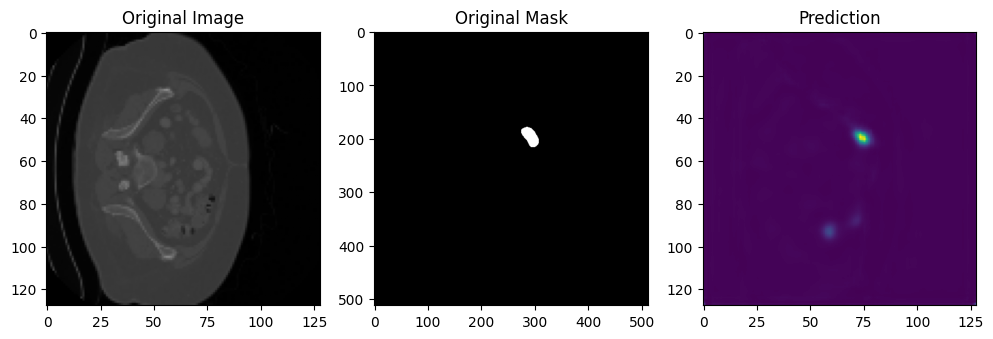

1/1 [==============================] - 0s 27ms/step


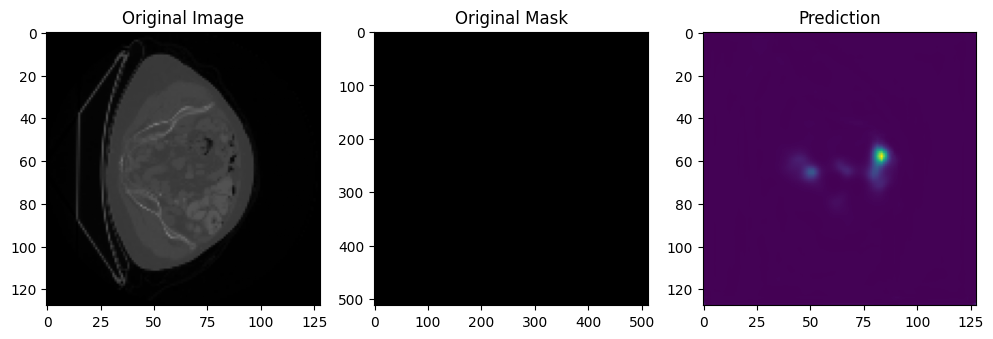

1/1 [==============================] - 0s 40ms/step


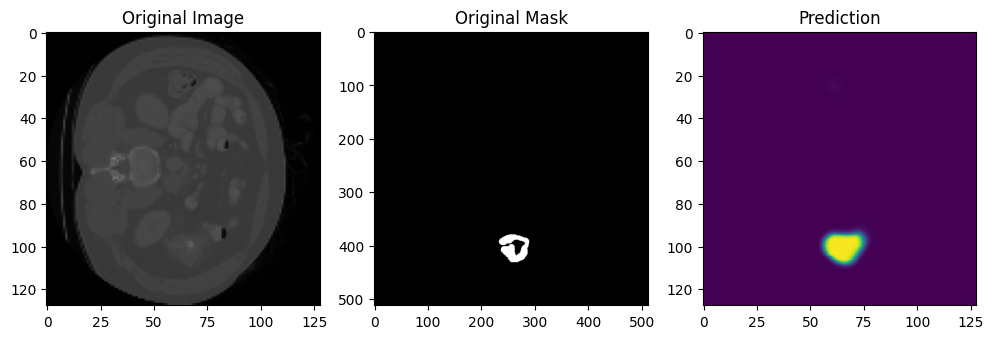

In [ ]:
for i in range(10):
  idx = random.randint(0,len(dataset))
    
  image = cv2.imread(dataset['Image Slices'][idx])
  mask = cv2.imread(dataset['Label Slices'][idx])
    
  img = cv2.resize(image,(IMGHEIGHT, IMGWIDTH))
  img = img/255
  img = img[np.newaxis,:,:,:]
  pred=unet_resnet.predict(img)
    
  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,3,2)
  plt.imshow(mask)
  plt.title('Original Mask')
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred))
  plt.title('Prediction')
  plt.show()